# Activation

## Fake data

In [124]:
import pandas as pd
import numpy as np
from faker import Faker
from scipy.stats import poisson, gamma, bernoulli, expon

def create_fake_data(num_customers=100, start_date='2020-01-01', end_date='2024-01-01'):
    fake = Faker()
    Faker.seed(42)
    np.random.seed(42)
    
    start_date = pd.Timestamp(start_date)
    end_date = pd.Timestamp(end_date)
    
    customer_ids = [fake.uuid4() for _ in range(num_customers)]
    
    data = []
    
    # Parameters for Poisson emissions from Gamma distributions for unactivated and activated states
    unactivated_params = {'shape': 2, 'rate': 0.5}
    activated_params = {'shape': 8, 'rate': 0.2}
    
    # Transition probabilities
    transition_matrix = np.array([[0.9, 0.1], [0.1, 0.9]])
    
    # Mean time to conversion in days
    mean_time_to_convert = 14
    
    for customer_id in customer_ids:
        workspace_creation_date = pd.Timestamp(fake.date_between(start_date=start_date, end_date=end_date))
        churn_date = workspace_creation_date + pd.Timedelta(days=np.random.randint(30, 365*2))  # Churn between 1 month and 2 years
        
        # Determine if and when the customer converts
        converts = bernoulli.rvs(0.04)
        if converts:
            # Time to conversion follows an exponential distribution
            time_to_convert = int(expon.rvs(scale=mean_time_to_convert))
            conversion_date = workspace_creation_date + pd.Timedelta(days=time_to_convert)
            if conversion_date > churn_date:
                conversion_date = churn_date
        else:
            conversion_date = None
        
        current_state = 0  # Start in the unactivated state
        
        for single_date in pd.date_range(start=workspace_creation_date, end=churn_date):
            features = []
            
            if current_state == 0:
                # Emissions for the unactivated state
                for _ in range(10):
                    lam = gamma.rvs(a=unactivated_params['shape'], scale=1/unactivated_params['rate'])
                    features.append(poisson.rvs(lam))
            else:
                # Emissions for the activated state
                for _ in range(10):
                    lam = gamma.rvs(a=activated_params['shape'], scale=1/activated_params['rate'])
                    features.append(poisson.rvs(lam))
            
            # Transition to the next state
            current_state = np.random.choice([0, 1], p=transition_matrix[current_state])
            
            dim_1 = fake.random_int(min=1, max=5)
            dim_2 = fake.random_element(elements=('A', 'B', 'C', 'D', 'E'))
            dim_3 = fake.random_number(digits=2)
            
            data.append([customer_id, workspace_creation_date, single_date, churn_date, conversion_date, current_state] + features + [dim_1, dim_2, dim_3])
    
    columns = ['customer_id', 'workspace_creation_date', 'observation_date', 'churn_date', 'conversion_date', 'state'] + [f'feature_{i}' for i in range(1, 11)] + ['dim_1', 'dim_2', 'dim_3']
    return pd.DataFrame(data, columns=columns)

# Generate the data
data = create_fake_data(num_customers=2)

data

,customer_id,workspace_creation_date,observation_date,churn_date,conversion_date,state,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,dim_1,dim_2,dim_3
0,bdd640fb-0667-4ad1-9c80-317fa3b1799d,2022-12-11,2022-12-11,2023-04-22,None,0,3,1,3,2,5,2,2,0,1,15,5,A,75
1,bdd640fb-0667-4ad1-9c80-317fa3b1799d,2022-12-11,2022-12-12,2023-04-22,None,0,1,8,9,0,1,2,8,3,1,1,4,A,3
2,bdd640fb-0667-4ad1-9c80-317fa3b1799d,2022-12-11,2022-12-13,2023-04-22,None,0,2,1,4,3,3,10,4,10,12,2,1,B,29
3,bdd640fb-0667-4ad1-9c80-317fa3b1799d,2022-12-11,2022-12-14,2023-04-22,None,0,2,12,7,3,5,3,1,1,1,2,5,E,3
4,bdd640fb-0667-4ad1-9c80-317fa3b1799d,2022-12-11,2022-12-15,2023-04-22,None,0,2,6,2,2,1,6,2,4,8,8,5,B,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,23b8c1e9-3924-46de-beb1-3b9046685257,2021-09-16,2021-12-26,2021-12-30,None,1,45,52,47,27,38,26,39,53,27,49,5,E,95
235,23b8c1e9-3924-46de-beb1-3b9046685257,2021-09-16,2021-12-27,2021-12-30,None,1,68,16,30,12,67,80,73,31,27,28,1,B,39
236,23b8c1e9-3924-46de-beb1-3b9046685257,2021-09-16,2021-12-28,2021-12-30,None,1,23,20,8,34,39,31,14,47,47,79,1,E,3
237,23b8c1e9-3924-46de-beb1-3b9046685257,2021-09-16,2021-12-29,2021-12-30,None,0,49,42,45,75,63,36,31,32,53,25,3,E,86


## Data processing

In [125]:
def data_processing(data):
    # Add 'converted' column
    data['converted'] = data.apply(lambda row: 1 if pd.notnull(row['conversion_date']) and row['observation_date'] >= row['conversion_date'] else 0, axis=1)
    
    # Add 'time' column
    data['time'] = (data['observation_date'] - data['workspace_creation_date']).dt.days
    
    return data

data = data_processing(data)
data

,customer_id,workspace_creation_date,observation_date,churn_date,conversion_date,state,feature_1,feature_2,feature_3,feature_4,...,feature_6,feature_7,feature_8,feature_9,feature_10,dim_1,dim_2,dim_3,converted,time
0,bdd640fb-0667-4ad1-9c80-317fa3b1799d,2022-12-11,2022-12-11,2023-04-22,None,0,3,1,3,2,...,2,2,0,1,15,5,A,75,0,0
1,bdd640fb-0667-4ad1-9c80-317fa3b1799d,2022-12-11,2022-12-12,2023-04-22,None,0,1,8,9,0,...,2,8,3,1,1,4,A,3,0,1
2,bdd640fb-0667-4ad1-9c80-317fa3b1799d,2022-12-11,2022-12-13,2023-04-22,None,0,2,1,4,3,...,10,4,10,12,2,1,B,29,0,2
3,bdd640fb-0667-4ad1-9c80-317fa3b1799d,2022-12-11,2022-12-14,2023-04-22,None,0,2,12,7,3,...,3,1,1,1,2,5,E,3,0,3
4,bdd640fb-0667-4ad1-9c80-317fa3b1799d,2022-12-11,2022-12-15,2023-04-22,None,0,2,6,2,2,...,6,2,4,8,8,5,B,91,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,23b8c1e9-3924-46de-beb1-3b9046685257,2021-09-16,2021-12-26,2021-12-30,None,1,45,52,47,27,...,26,39,53,27,49,5,E,95,0,101
235,23b8c1e9-3924-46de-beb1-3b9046685257,2021-09-16,2021-12-27,2021-12-30,None,1,68,16,30,12,...,80,73,31,27,28,1,B,39,0,102
236,23b8c1e9-3924-46de-beb1-3b9046685257,2021-09-16,2021-12-28,2021-12-30,None,1,23,20,8,34,...,31,14,47,47,79,1,E,3,0,103
237,23b8c1e9-3924-46de-beb1-3b9046685257,2021-09-16,2021-12-29,2021-12-30,None,0,49,42,45,75,...,36,31,32,53,25,3,E,86,0,104


## Feature usage heatmap

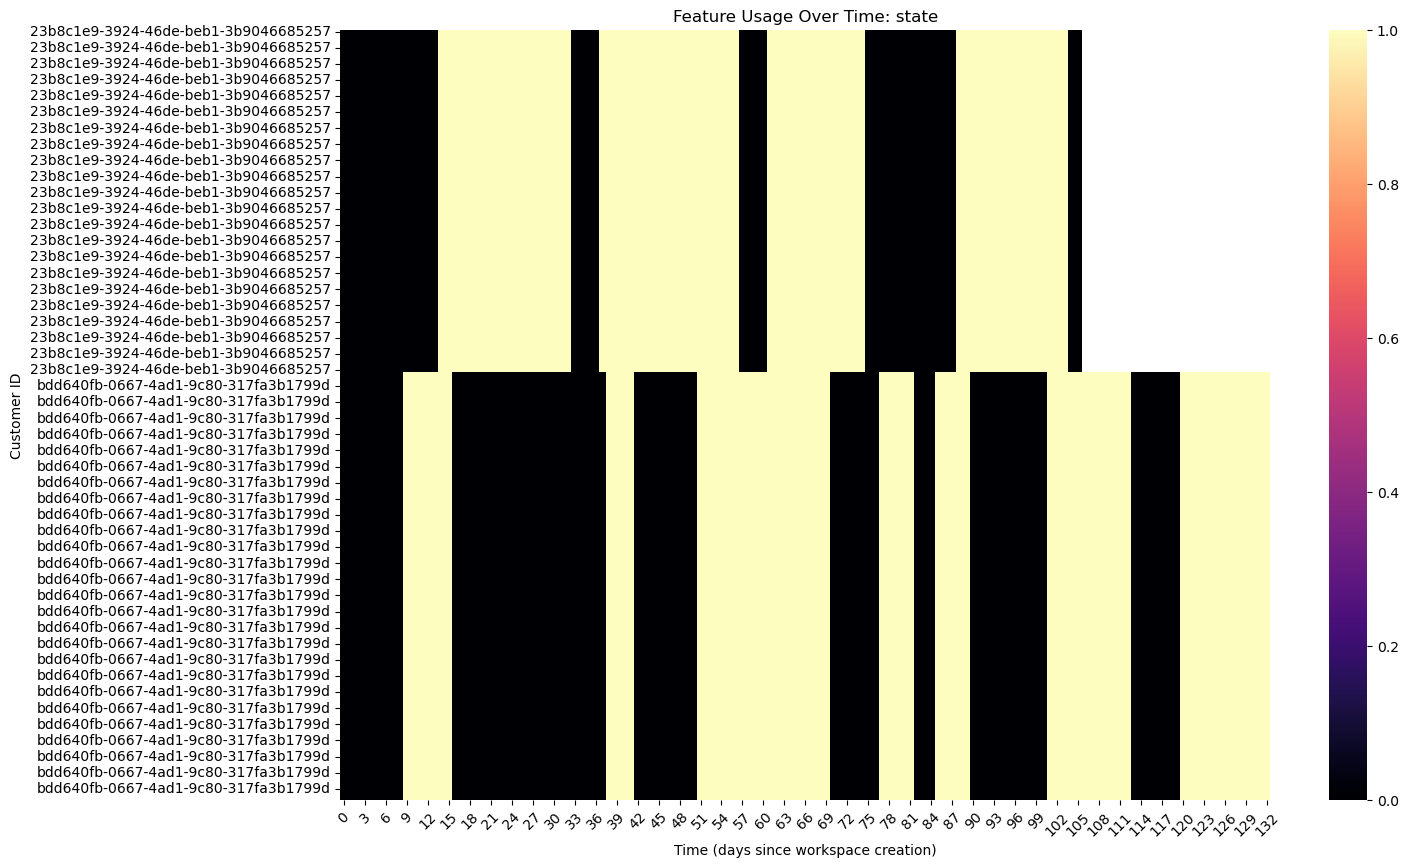

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def feature_usage_heatmap(data, feature):
    # Pivot the data to get a matrix where rows are customer_ids and columns are observation_dates
    heatmap_data = data.pivot(index='customer_id', columns='time', values=feature)
    
    # Sort by workspace_creation_date for a better visualization
    heatmap_data = heatmap_data.loc[data.set_index('customer_id').sort_values('workspace_creation_date').index]
    
    # Plot the heatmap
    plt.figure(figsize=(15, 10))
    sns.heatmap(heatmap_data, cmap='magma', cbar=True, linewidths=0.0)
    
    # Set plot labels and title
    plt.xlabel('Time (days since workspace creation)')
    plt.ylabel('Customer ID')
    plt.title(f'Feature Usage Over Time: {feature}')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    plt.show()


# Create the heatmap for a specific feature (e.g., 'feature_2')
feature_usage_heatmap(data, 'state')

## Hidden Markov Model

### Generative model

In [139]:
import torch
import torch.distributions as dist
from torch.optim import Adam
import pandas as pd

def generative_model(num_states=2, num_modalities=10):
    alpha_prior = torch.tensor([1.1] * num_states)
    state_prior = dist.Dirichlet(alpha_prior)
    
    alpha_transition = torch.tensor([[1.1, 1.1], [1.1, 1.1]])
    transition_model = dist.Dirichlet(alpha_transition).rsample()
    
    mu_prior = dist.LogNormal(torch.tensor(0.0), torch.tensor(1.0))
    sigma_prior = dist.Gamma(torch.tensor(2.0), torch.tensor(2.0))
    
    mu_params = mu_prior.sample((num_states, num_modalities))
    sigma_params = sigma_prior.sample((num_states, num_modalities))
    
    observation_model = []
    for state in range(num_states):
        state_distributions = [dist.Normal(mu, sigma) for mu, sigma in zip(mu_params[state], sigma_params[state])]
        observation_model.append(state_distributions)
    
    return state_prior, transition_model, observation_model

def variational_distribution(sequence_length, num_states):
    variational_params_x = torch.nn.Parameter(torch.randn(sequence_length, num_states).softmax(dim=-1))
    variational_params_theta = torch.nn.Parameter(torch.randn(num_states).softmax(dim=-1))
    return variational_params_x, variational_params_theta



In [ ]:
def calculate_elbo(data, state_prior, transition_model, observation_model, variational_params_x, variational_params_theta):
    sequence_length, num_modalities = data.shape
    num_states = variational_params_x.shape[1]
    
    log_likelihood = 0
    entropy = 0
    
    for t in range(sequence_length):
        for s in range(num_states):
            log_prob = torch.log(state_prior.sample()[s])
            if t > 0:
                log_prob += torch.log(transition_model[variational_params_x[t-1].argmax().item(), s])
            for m in range(num_modalities):
                log_prob += observation_model[s][m].log_prob(data[t, m])
            log_likelihood += variational_params_x[t, s] * log_prob
        
        entropy += dist.Categorical(probs=variational_params_x[t]).entropy()
    
    for s in range(num_states):
        log_prob_theta = torch.log(state_prior.sample()[s])
        log_likelihood += variational_params_theta[s] * log_prob_theta
    
    entropy += dist.Categorical(probs=variational_params_theta).entropy()
    
    elbo = log_likelihood + entropy
    return elbo

#E Step (state estimation)
def e_step(data, state_prior, transition_model, observation_model, variational_params_x, variational_params_theta, optimizer_x):
    optimizer_x.zero_grad()
    elbo = calculate_elbo(data, state_prior, transition_model, observation_model, variational_params_x, variational_params_theta)
    vfe = -elbo
    loss = vfe
    print(f'E-Step Free energy: {vfe}')
    loss.backward()
    optimizer_x.step()
    with torch.no_grad():
        variational_params_x.data = variational_params_x.data.softmax(dim=-1)

#M Step (Parameter estimation)
def m_step(data, state_prior, transition_model, observation_model, variational_params_x, variational_params_theta, optimizer_theta):
    optimizer_theta.zero_grad()
    elbo = calculate_elbo(data, state_prior, transition_model, observation_model, variational_params_x, variational_params_theta)
    vfe = -elbo
    loss = vfe
    print(f'M-Step Free energy: {vfe}')
    loss.backward()
    optimizer_theta.step()
    with torch.no_grad():
        variational_params_theta.data = variational_params_theta.data.softmax(dim=-1)

def vbem(data, num_states=2, num_iterations=1000, lr=0.001):
    sequence_length, num_modalities = data.shape

    state_prior, transition_model, observation_model = generative_model(num_states, num_modalities)
    variational_params_x, variational_params_theta = variational_distribution(sequence_length, num_states)

    optimizer_x = Adam([variational_params_x], lr=lr)
    optimizer_theta = Adam([variational_params_theta], lr=lr)

    for iteration in range(num_iterations):
        e_step(data, state_prior, transition_model, observation_model, variational_params_x, variational_params_theta, optimizer_x)
        m_step(data, state_prior, transition_model, observation_model, variational_params_x, variational_params_theta, optimizer_theta)

    return variational_params_x, variational_params_theta, transition_model, observation_model

def fit_vbem_to_customers(customer_data, num_states=2, num_iterations=1000, lr=0.1):
    results = {}
    for customer_id, group in customer_data.groupby('customer_id'):
        features = group.sort_values('time')[['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 
                                              'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10']].values
        data_tensor = torch.tensor(features, dtype=torch.float32)
        variational_params_x, variational_params_theta, transition_model, observation_model = vbem(data_tensor, num_states, num_iterations, lr)
        results[customer_id] = {
            'variational_params_x': variational_params_x,
            'variational_params_theta': variational_params_theta,
            'transition_model': transition_model,
            'observation_model': observation_model
        }
    return results

# Fit VBEM model to each customer
results = fit_vbem_to_customers(data)

# Print the results for each customer
for customer_id, result in results.items():
    print(f"Results for {customer_id}:")
    print("Variational Parameters (state estimates):")
    print(result['variational_params_x'])
    print(result['variational_params_theta'])
    print("\nTransition Model:")
    print(result['transition_model'])
    print("\nObservation Model Parameters (mu, sigma):")
    for state in range(len(result['observation_model'])):
        for i, obs in enumerate(result['observation_model'][state]):
            print(f"State {state + 1}, Modality {i + 1}: mu = {obs.mean.item():.4f}, sigma = {obs.stddev.item():.4f}")
    print("\n" + "="*50 + "\n")